In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense

2.3.0


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2022872276420053736,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4174090714885718521
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15852160835163607692
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
train = pd.read_csv(
    'data/train.csv',
    usecols=[1, 2, 3, 4, 5, 7, 8, 9],
    nrows=10**7*1,
    dtype={
        'timestamp': 'int64',
        'user_id': 'int32',
        'content_id': 'int16',
        'content_type_id': 'int8',
        'task_container_id': 'int16',
        'answered_correctly':'int8',
        'prior_question_elapsed_time': 'float32',
        'prior_question_had_explanation': 'boolean'
    }
)
train

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,1,NaN,<NA>
1,56943,115,5716,0,2,1,37000.0,False
2,118363,115,128,0,0,1,55000.0,False
3,131167,115,7860,0,3,1,19000.0,False
4,137965,115,7922,0,4,1,11000.0,False
...,...,...,...,...,...,...,...,...
9999995,646228695,216747867,8805,0,410,1,23000.0,True
9999996,646321314,216747867,5708,0,411,0,13000.0,True
9999997,646393443,216747867,5434,0,412,0,66000.0,True
9999998,646445632,216747867,6429,0,413,1,37000.0,True


In [4]:
train.drop(columns=['timestamp', 'user_id', 'content_type_id', 'task_container_id', 'prior_question_had_explanation'], inplace=True)
train

,content_id,answered_correctly,prior_question_elapsed_time
0,5692,1,NaN
1,5716,1,37000.0
2,128,1,55000.0
3,7860,1,19000.0
4,7922,1,11000.0
...,...,...,...
9999995,8805,1,23000.0
9999996,5708,0,13000.0
9999997,5434,0,66000.0
9999998,6429,1,37000.0


In [5]:
train_df = train.iloc[:int(9 /10 * len(train))]
validation_df = train.iloc[int(9 /10 * len(train)):]

In [6]:
len(train_df)

9000000

In [7]:
len(validation_df)

1000000

In [8]:
questions_df = pd.read_csv(
    'data/questions.csv',                         
    usecols=[0, 3],
    dtype={
        'question_id': 'int16',
        'part': 'int8'}
)
questions_df

,question_id,part
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
13518,13518,5
13519,13519,5
13520,13520,5
13521,13521,5


In [9]:
lectures_df = pd.read_csv('data/lectures.csv')
lectures_df

,lecture_id,tag,part,type_of
0,89,24584,5,concept
1,100,22243,1,concept
2,185,7035,6,concept
3,192,31458,5,solving question
4,317,19653,5,solving question
...,...,...,...,...
413,32535,20004,5,solving question
414,32570,4358,3,solving question
415,32604,9093,6,concept
416,32625,23993,2,concept


In [10]:
def mean_count_std_skew(data):
  # The return value of this function is groupby content_id, 
  # so the number of rows will be 0~13523 for any number of data
  
  # remobe lecture
  data = data[data['answered_correctly'] != -1]
  data = data.groupby('content_id')
  
  answered_correctly = data.agg({'answered_correctly': ['mean', 'count', 'std', 'skew']})
  answered_correctly.columns = [
    'mean_accuracy', 
    'question_asked', 
    'std_accuracy', 
    'skew_accuracy']

  prior_question_elapsed_time = data.agg({'prior_question_elapsed_time': ['mean']})
  prior_question_elapsed_time.columns = [
       'prior_question_elapsed_time_mean'] 

  result =  answered_correctly.merge(prior_question_elapsed_time, how='left', on='content_id')
  return result


In [11]:
train_df = train_df.merge(mean_count_std_skew(train_df), how='left', on='content_id')
validation_df = validation_df.merge(mean_count_std_skew(validation_df), how='left', on='content_id')

In [12]:
train_df

,content_id,answered_correctly,prior_question_elapsed_time,mean_accuracy,question_asked,std_accuracy,skew_accuracy,prior_question_elapsed_time_mean
0,5692,1,NaN,0.736842,3211.0,0.440416,-1.076209,24294.363281
1,5716,1,37000.0,0.733610,2166.0,0.442172,-1.057625,22023.574219
2,128,1,55000.0,0.973502,1736.0,0.160656,-5.901400,24448.480469
3,7860,1,19000.0,0.953392,1931.0,0.210852,-4.305024,19380.416016
4,7922,1,11000.0,0.951708,1698.0,0.214446,-4.217758,20380.681641
...,...,...,...,...,...,...,...,...
8999995,7886,0,20000.0,0.856201,758.0,0.351118,-2.034318,23604.751953
8999996,7957,1,25000.0,0.872314,791.0,0.333952,-2.235398,22223.843750
8999997,90,1,20000.0,0.955814,430.0,0.205748,-4.451511,22366.279297
8999998,10414,1,19000.0,0.866426,554.0,0.340502,-2.160070,23420.937500


In [13]:
validation_df

,content_id,answered_correctly,prior_question_elapsed_time,mean_accuracy,question_asked,std_accuracy,skew_accuracy,prior_question_elapsed_time_mean
0,3992,1,19000.0,0.829787,47.0,0.379883,-1.813426,22652.173828
1,9510,0,15000.0,0.500000,46.0,0.505525,0.000000,26369.564453
2,5214,1,13000.0,0.756757,111.0,0.430987,-1.213346,24872.726562
3,5334,0,16000.0,0.709544,241.0,0.454918,-0.928946,24602.003906
4,3722,1,16000.0,0.827273,110.0,0.379741,-1.755581,22100.917969
...,...,...,...,...,...,...,...,...
999995,8805,1,23000.0,0.611940,67.0,0.490986,-0.470012,22805.970703
999996,5708,0,13000.0,0.467710,511.0,0.499445,0.129810,25419.212891
999997,5434,0,66000.0,0.483871,186.0,0.501089,0.065076,23058.107422
999998,6429,1,37000.0,0.535503,338.0,0.499477,-0.143007,24472.484375


In [14]:
features = [
    'mean_accuracy', 
    'question_asked', 
    'std_accuracy', 
    'skew_accuracy',
    'prior_question_elapsed_time_mean'
]
target = 'answered_correctly'

In [15]:
def create_nn():
  model = tf.keras.Sequential([
       tf.keras.layers.Input(5),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dense(50, activation="relu"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(25, activation="relu"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(1, activation="sigmoid")
      ]
  )
  model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
  return model

In [16]:
model = create_nn()
history = model.fit(np.array(train_df[features], np.float), 
          np.array(train_df[target], np.float),
          validation_split=0.2,
          epochs=3)

Epoch 1/3
225000/225000 [==============================] - 643s 3ms/step - loss: nan - accuracy: 0.3349 - val_loss: nan - val_accuracy: 0.3392
Epoch 2/3
225000/225000 [==============================] - 710s 3ms/step - loss: nan - accuracy: 0.3349 - val_loss: nan - val_accuracy: 0.3392
Epoch 3/3
225000/225000 [==============================] - 631s 3ms/step - loss: nan - accuracy: 0.3349 - val_loss: nan - val_accuracy: 0.3392


In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
model.predict(validation_df[features])

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

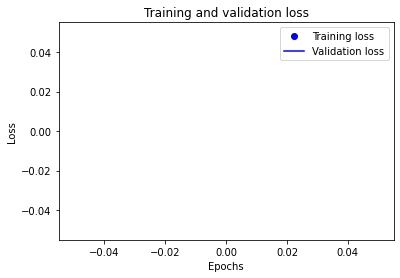

In [19]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

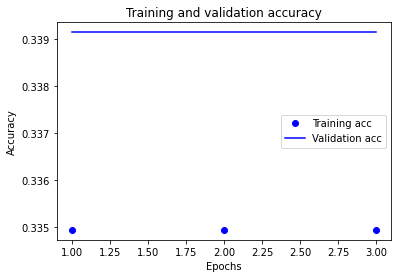

In [20]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()